In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import scipy.stats as stats
import os

In [2]:
l_new = [
    '$\\it{Ae. aegypti}$',
    '$\\it{Ae. albopictus}$',
    '$\\it{Ae. annulipes}$-group',
    '$\\it{Ae. caspius}$',
    '$\\it{Ae. cataphylla}$',
    '$\\it{Ae. cinereus-geminus\\ }$pair',
    '$\\it{An. claviger - petragnani\\ }$pair',
    '$\\it{Ae. communis-punctor\\ }$pair',
    '$\\it{Ae. japonicus}$',
    '$\\it{Ae. koreicus}$',
    '$\\it{An. maculipennis}$ s.l.',
    '$\\it{Cx. modestus}$',
    '$\\it{Cs. morsitans-fumipennis\\ }$pair',
    'other',
    '$\\it{Cx. torrentium-pipiens\\ }$s.l. pair',
    '$\\it{Cq. richiardii}$',
    '$\\it{Ae. rusticus}$',
    '$\\it{An. stephensi}$',
    '$\\it{Ae. sticticus}$',
    '$\\it{Ae. vexans}$',
    '$\\it{Cx. vishnui}$-group',]

In [3]:
df_ref = pd.read_pickle("data/references/database_reference_MLREADY.pkl")
DF = pd.DataFrame()

for dataframe in os.listdir("results/final_models"):
    if dataframe.endswith(".pkl") and dataframe.startswith("test"): 
        df = pd.read_pickle(os.path.join("results/final_models", dataframe))
        fold = dataframe.split("_")[2]
        df["Image ID"] = [x.split("/")[-1].split(".")[0].split("_")[-1] for x in df["PATH"].values]
        df["Fold"] = fold.split(".")[0]
        df["correct"] = df["PRED"] == df["TARGET"]
        df_merged = pd.merge(df, df_ref, on="Image ID", how="inner")
        DF = pd.concat([DF, df_merged])

Text(0.5, 1.0, '2.426 * x + -7.876')

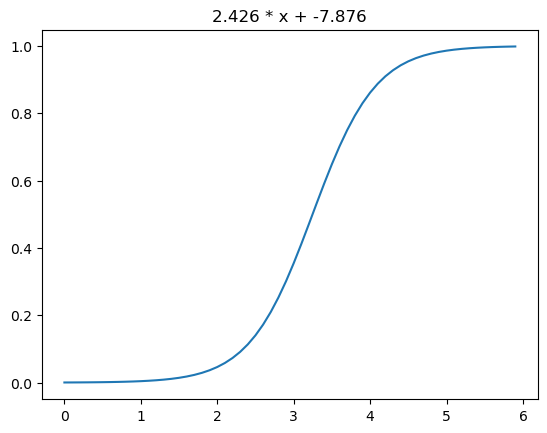

In [4]:
# Calibration
from sklearn.linear_model import LogisticRegression
base_clf = LogisticRegression()
train = np.asarray(DF["PRED%"]).reshape(-1, 1)
label = np.asarray(DF["correct"]).reshape(-1, 1).ravel()
base_clf.fit(train, label)

# Extract coefficients and intercept
coefficients = base_clf.coef_[0]
intercept = base_clf.intercept_[0]

# Define the logistic function
def logistic_function(x, coefficients, intercept):
    z = np.dot(x, coefficients) + intercept
    return 1 / (1 + np.exp(-z))

plt.plot(np.arange(0,6,0.1), logistic_function(np.arange(0,6,0.1).reshape(-1, 1), coefficients, intercept))
plt.title(str(round(coefficients[0],3)) + " * x + " + str(round(intercept,3)))

/var/folders/zq/vkd6f9tx4gdctwbs4b3j895w0000gn/T/ipykernel_98804/2593110161.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  heatmap_mean_annot = pd.DataFrame(heatmap_mean).applymap(lambda x: "-" if x == 0 else ("<0.1" if x < 0.1 else ("100" if x == 100.0 else f"{x:.1f}")))
/var/folders/zq/vkd6f9tx4gdctwbs4b3j895w0000gn/T/ipykernel_98804/2593110161.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  heatmap_mean = pd.DataFrame(heatmap_mean).applymap(lambda x: 0 if x == 0 else (0.1 if x < 0.1 else x))


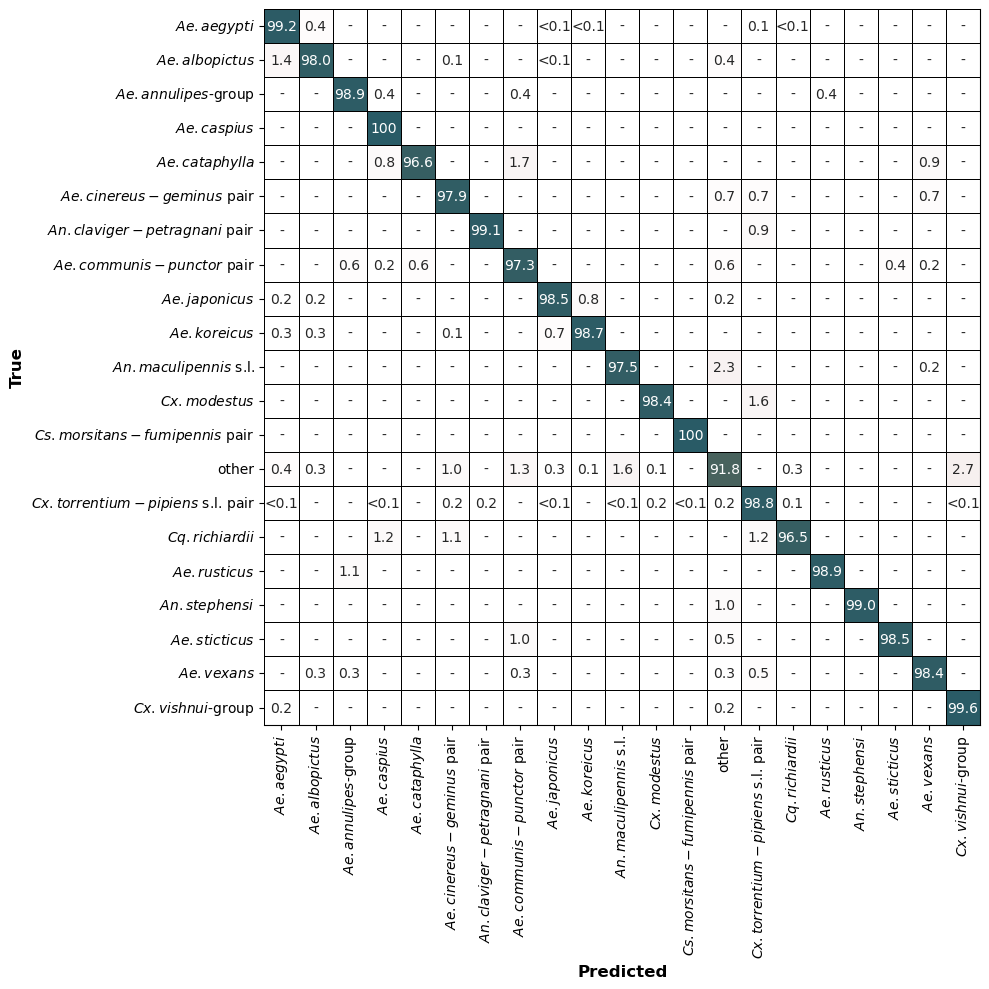

In [5]:
# Figure 4: Average Confusion Matrix 
heatmap = pd.DataFrame()
heatmap_dict = {}
DF = DF.sort_values(by="TARGET")
# Create the confusion matrix for each fold
for fold in DF["Fold"].unique():
    heatmap_dict[fold] = pd.crosstab(DF["TARGET"].loc[DF["Fold"] == fold], DF["PRED"].loc[DF["Fold"] == fold], normalize="index")

heatmap_mean = np.mean([heatmap_dict[x] for x in heatmap_dict.keys()], axis=0)*100
heatmap_std = np.std([heatmap_dict[x] for x in heatmap_dict.keys()], axis=0)*100

# Replace 0 values with "-" and values under 0.1 with "<0.1"
heatmap_mean_annot = pd.DataFrame(heatmap_mean).applymap(lambda x: "-" if x == 0 else ("<0.1" if x < 0.1 else ("100" if x == 100.0 else f"{x:.1f}")))
heatmap_mean = pd.DataFrame(heatmap_mean).applymap(lambda x: 0 if x == 0 else (0.1 if x < 0.1 else x))

fig, ax = plt.subplots(1, figsize=(10,10))
# Define the colors for the palette
colors = ["white", "#802823", "#A27942", "#265A67"]
# Create the custom palette
custom_palette = sb.blend_palette(colors, as_cmap=True)

sb.heatmap(heatmap_mean, annot=heatmap_mean_annot, fmt="", linewidth=.5, cmap=custom_palette, vmax=101, linecolor="black", cbar=False, ax=ax)

ax.spines.right.set_visible(True)
ax.spines.bottom.set_visible(True)

ax.set_yticklabels(l_new, rotation=0, fontsize=10)
ax.set_xticklabels(l_new, rotation=90, fontsize=10)

ax.set_xlabel("Predicted", fontsize=12, fontweight="bold")
ax.set_ylabel("True", fontsize=12, fontweight="bold")

plt.tight_layout()

In [6]:
def get_avg_metric(df, with_ci = True):
    accuracy_ls, f1_ls = [], []
    for fold in df["Fold"].unique():
        df_fold = df.loc[df["Fold"] == fold]

        accuracy_ls.append(metrics.balanced_accuracy_score(df_fold["TARGET"], df_fold["PRED"]))
        f1_ls.append(metrics.f1_score(df_fold["TARGET"], df_fold["PRED"], average="macro"))

    acc_avg = np.mean(accuracy_ls)
    f1_avg = np.mean(f1_ls)

    if with_ci:
        acc_ci = stats.t.interval(0.95, len(accuracy_ls)-1, loc=np.mean(accuracy_ls), scale=stats.sem(accuracy_ls))
        f1_ci = stats.t.interval(0.95, len(f1_ls)-1, loc=np.mean(f1_ls), scale=stats.sem(f1_ls))
    

    return acc_avg*100, f1_avg*100, acc_ci, f1_ci

In [7]:
# Get average metrics
acc_avg, f1_avg, acc_ci, f1_ci = get_avg_metric(DF)
print(f"Accuracy: {acc_avg:.2f}% (95% CI: {acc_ci[0]*100:.2f}% - {acc_ci[1]*100:.2f}%)")
print(f"F1 Score: {f1_avg:.2f}% (95% CI: {f1_ci[0]*100:.2f}% - {f1_ci[1]*100:.2f}%)")

Accuracy: 98.18% (95% CI: 97.79% - 98.56%)
F1 Score: 97.61% (95% CI: 96.87% - 98.36%)


In [8]:
acc_avg, f1_avg, acc_ci, f1_ci = get_avg_metric(DF)

In [17]:
metrics.balanced_accuracy_score(DF.loc[DF["Fold"] == "2"]["TARGET"], DF.loc[DF["Fold"] == "2"]["PRED"])
metrics.f1_score(DF.loc[DF["Fold"] == "2"]["TARGET"], DF.loc[DF["Fold"] == "2"]["PRED"], average="macro")

0.9821726461067496

In [10]:
"""# Find all missclassified images
df_missclassified = DF.loc[(DF["TARGET"] != DF["PRED"]) & (DF["Fold"] != 0)]
files = df_missclassified["File Name"].values

# Plot all images that were missclassified
fig, axes = plt.subplots(27, 8, figsize=(40, 60))
for i, ax in enumerate(axes.flat):
    if i < len(files):
        ax.imshow(plt.imread("data/mos_dataset_processed/" + files[i].split(".")[0] + ".png"))
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.axis("off")

plt.tight_layout()
plt.savefig("figures/wing_damage.png", dpi=300)"""

'# Find all missclassified images\ndf_missclassified = DF.loc[(DF["TARGET"] != DF["PRED"]) & (DF["Fold"] != 0)]\nfiles = df_missclassified["File Name"].values\n\n# Plot all images that were missclassified\nfig, axes = plt.subplots(27, 8, figsize=(40, 60))\nfor i, ax in enumerate(axes.flat):\n    if i < len(files):\n        ax.imshow(plt.imread("data/mos_dataset_processed/" + files[i].split(".")[0] + ".png"))\n        ax.set_xticks([])\n        ax.set_yticks([])\n    else:\n        ax.axis("off")\n\nplt.tight_layout()\nplt.savefig("figures/wing_damage.png", dpi=300)'